In [50]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None
    
def dynamical_activity(gamma, omega):
    numerator = 4*gamma*omega**2
    denominator = gamma**2 + 8*omega**2
    return numerator / denominator

def quantum_dynamical_activity(gamma, omega):
    numerator = 128*omega**4
    denominator = gamma**3 + 8 * gamma * omega**2
    return numerator / denominator


In [90]:
# Parameters
Gamma = 1
Omega = 0.1
dt = 0.0012
tf = 10
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 0)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, g])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
g_un = unconditional_result.expect[2]

N_cutoff = 1

# Compute dynamical activity per unity time
K = sum([expect(c_op.dag() * c_op, rhoss) for c_op in c_ops])
Q = quantum_dynamical_activity(Gamma, Omega)

In [91]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-10, Nm, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
Pn_vec = diff.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 8333/8333 [00:18<00:00, 460.59it/s]


In [93]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

In [96]:
ntraj = 200
result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[sy, g], store_measurement=True, ntraj=ntraj)

10.0%. Run time:   1.95s. Est. time left: 00:00:00:17
20.0%. Run time:   3.92s. Est. time left: 00:00:00:15
30.0%. Run time:   5.89s. Est. time left: 00:00:00:13
40.0%. Run time:   7.87s. Est. time left: 00:00:00:11
50.0%. Run time:   9.84s. Est. time left: 00:00:00:09
60.0%. Run time:  11.82s. Est. time left: 00:00:00:07
70.0%. Run time:  13.81s. Est. time left: 00:00:00:05
80.0%. Run time:  15.77s. Est. time left: 00:00:00:03
90.0%. Run time:  17.75s. Est. time left: 00:00:00:01
Total run time:  19.72s


In [103]:
dJ = np.real(np.array(result.measurement).T[0])
J = np.cumsum(dJ, axis=0)*dt

In [104]:
# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in J.T])
inds = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds)]

In [105]:
SNR = Et**2 / Var

print(SNR/(Et*K), 1)
print(SNR/(Et*(K+Q)), 1)

6.147411492575783 1
4.657129918618014 1


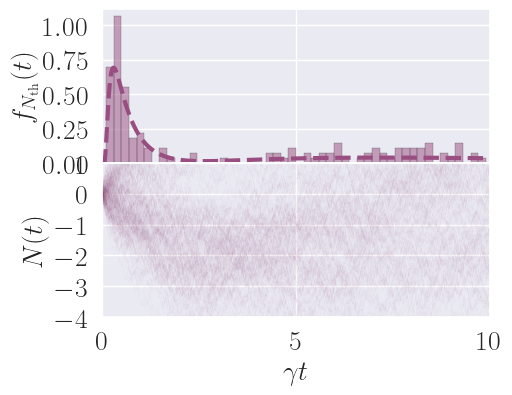

In [106]:
#----------------- Plotting -----------------#

fig = plt.figure(figsize=(5, 4))

color = [0.6, 0.3, 0.5]

plt.subplot(2, 1, 1)
# plt.plot(t, P0, color='k', linestyle='-', linewidth=3, alpha=1)
plt.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
plt.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.3)
# plt.vlines(Et, 0, dGt[np.argmin(np.abs(t-Et))], color='k', linestyle='--', linewidth=2, alpha=1)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
# plt.yticks(np.arange(0.0, 0.15, 0.05), fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(0.0, 0.15)
plt.xlim(0, tf)
plt.ylabel(r"$f_{N_{\rm th}}(t)$", fontsize=20)


plt.subplot(2, 1, 2)
plt.plot(t, J[:, :2000], color=color, linestyle='-', linewidth=0.1, alpha=0.05)

plt.yticks(fontsize=20)
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.ylim(-4, N_cutoff)
plt.xlim(0, tf)

plt.xlabel(r'$\gamma t$', fontsize=20)
plt.ylabel(r'$N(t)$', fontsize=20)

plt.subplots_adjust(hspace=0.0)

plt.show()

#----------------- Save -----------------#
# fig.savefig('Figures/Garrahan_homodyne_example.png', bbox_inches='tight', dpi=200)

# Repeat analysis but loop over different values of $\bar{n}$ and $\Omega$ creating a surface plot of the SNR


In [86]:
saved_data = False

# parameters
Omegas = np.arange(0.1, 1, 0.1)
gamma = 1

if saved_data:
    # load data
    import pickle 
    # load the dictionary
    with open('Data/homodyne_data3.pickle', 'rb') as handle:
        data = pickle.load(handle)

    # upack data
    Et_vals = data['Et_vals']
    Var_vals = data['Var_vals']
    SNR_vals = data['SNR_vals']
    K_vals = data['K_vals']
    Q_vals = data['Q_vals']
    nbars = data['nbar']
    Omegas = data['Omega']

else:

    dt = 0.0012
    tf = 100
    t = np.arange(0, tf, dt)

    # Define system operators
    sp = sigmap()
    sm = sigmam()
    sx = sigmax()
    sz = sigmaz()

    # counting params
    nu_k = [0, -1, 1]
    # number of chargers to truncate at 

    Nm = 20
    dN = 0.06
    N = np.arange(-10, Nm, dN)


    # initialise matrices
    Et_vals = np.zeros(len(Omegas))
    Var_vals = np.zeros(len(Omegas))
    SNR_vals =np.zeros(len(Omegas))
    K_vals = np.zeros(len(Omegas))
    Q_vals = np.zeros(len(Omegas))

    count = 1

    for j, Omega in enumerate(Omegas):
        
        print('Omega = ', Omega)
        print(count, 'out of', len(Omegas), 'iterations')
        count += 1
        
        # Define Hamiltonian
        H = Omega*sx

        # define dissipator and Hamiltonian
        c_ops = [1j*np.sqrt(Gamma) * sm]    

        # Compute dynamical activity per unity time
        K_vals[j] = dynamical_activity(gamma, Omega)
        Q_vals[j] = quantum_dynamical_activity(gamma, Omega)

        # Compute initial state
        rho0 = operator_to_vector(steadystate(H, c_ops))

        # ------ Solve n-resolved method with absorbing boundary conditions ------ #
        diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
        Pn_vec = diff.solve(rho0)

        # Compute survival probability
        P0 = np.sum(Pn_vec, axis=0)
        dGt = -np.gradient(P0, dt)

        # Compute mean and variance of distribution
        Et = np.sum(dGt * t)*dt
        Var = np.sum(dGt * t**2 )*dt - Et**2

        SNR = Et**2 / Var

        # Compute mean and variance of distribution
        Et_vals[j] = Et
        Var_vals[j] = Var

        SNR_vals[j] = SNR

Omega =  0.1
1 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:45<00:00, 786.99it/s]


Omega =  0.2
2 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:40<00:00, 831.22it/s] 


Omega =  0.30000000000000004
3 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:45<00:00, 792.04it/s]


Omega =  0.4
4 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [02:26<00:00, 568.80it/s]


Omega =  0.5
5 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:47<00:00, 773.80it/s]


Omega =  0.6
6 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [02:13<00:00, 626.01it/s]


Omega =  0.7000000000000001
7 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [02:00<00:00, 694.01it/s]


Omega =  0.8
8 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:43<00:00, 807.67it/s]


Omega =  0.9
9 out of 9 iterations
Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 83333/83333 [01:46<00:00, 782.00it/s]


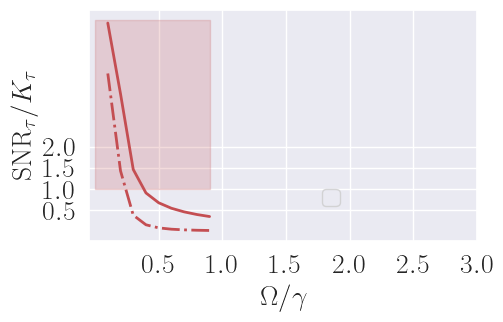

In [98]:
# compute both inequalitys
ineq1 = SNR_vals / (Et_vals*K_vals)
ineq2 = SNR_vals / (Et_vals*(K_vals+Q_vals))

# plot as a function of Omega
fig = plt.figure(figsize=(5, 3))



colors = ['r', 'g', 'b']

plt.plot(Omegas, ineq1, '-', color=colors[0], linewidth=2)
plt.plot(Omegas, ineq2, '-.', color=colors[0], linewidth=2)

plt.fill_betweenx([1, 5], 0, Omegas[-1], color='r', alpha=0.2)
# plt.xlim(0.11, Omegas[-1])
# plt.ylim(0.005, 2)

plt.yticks(np.arange(0.5, 2.5, 0.5), fontsize=20)
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3], fontsize=20)
plt.xlabel(r'$\Omega/\gamma$', fontsize=20)
plt.ylabel(r'${\rm SNR}_{\tau}/K_{\tau}  $', rotation=90, fontsize=20)

plt.legend(fontsize=16, loc=(0.6,0.15))
# plt.yscale('log')

plt.show()

In [81]:
# compute both inequalitys
ineq1 = SNR_vals / (Et_vals*K_vals)
ineq2 = SNR_vals / (Et_vals*(K_vals+Q_vals))

/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_38076/86895819.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ineq1 = SNR_vals / (Et_vals*K_vals)
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_38076/86895819.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ineq2 = SNR_vals / (Et_vals*(K_vals+Q_vals))
